In [1]:
import mysql
import mysql.connector
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
import requests 
import numpy as np 
import cv2 
from io import BytesIO
import os
import glob
import joblib
import random

from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet50_Weights, DenseNet169_Weights
import  torch.nn.functional as F

import MeCab
from konlpy.tag import Okt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT2/MyModule')
from KDTModule import *

In [2]:
torch.manual_seed(1)

In [3]:
# # csv -> DataFrame 변환
# df = pd.read_csv('movieDF.csv')
# df.info()

In [4]:
conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'signcity114',
    database = 'MyDB'
)

cursor = conn.cursor()

query = """
SELECT * FROM movie
where genre not like '%, %'
and (genre is not null)
and (poster_link is not null)
and (genre not like '%실험영화%')
and (genre not like '%무성 영화%')
and (genre not like '%단편 영화%')
and (genre not like '%흑백 영화%')
and (poster_link = 'https://image.cine21.com/resize/www1/common/content19_1[X230,330].jpg');"""

df2 = pd.read_sql(query, conn)
df2

/var/folders/ld/7fj1069x6q7fr5894rwywdk40000gn/T/ipykernel_57000/2502298671.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query, conn)


,id,ko_name,en_name,year,country,grade,genre,runtime,release_date,audience,director,story,poster_link
0,11910,마녀,Temptress,1994,미국,청소년 관람불가,범죄,90,1994-10-19,1019.0,로렌스 레노프,카린 스완은 젊고 아름다운 사진작가로 스튜디오를 경영하고 있다. 촬영차 인도에 다녀...,https://image.cine21.com/resize/www1/common/co...
1,11969,밤의 연인,Illicit Dreams,2000,미국,청소년 관람불가,멜로·로맨스,95,1994-10-29,1882.0,나단 스티븐스,성공한 사업가 다니엘 데이비스의 아내 모이라는 돈과 지위 무엇 하나 부러울 게 없는...,https://image.cine21.com/resize/www1/common/co...
2,12193,바디 체크,Body Language,1995,미국,청소년 관람불가,범죄,101,1997-09-27,712.0,조지 케이스,유능한 변호사 개빈은 자동차 접촉 사고로 우연히 도라라는 여자를 만난다. 접촉사고는...,https://image.cine21.com/resize/www1/common/co...
3,12739,졸업파티,Prom Night IV: Deliver Us from Evil,1992,미국,청소년 관람불가,공포,115,1993-10-30,1984.0,클레이 보리스,"1957년, '무도회의 여왕' 파티가 개최되고 있는 해밀튼 고교. 닉과 리사는 파트...",https://image.cine21.com/resize/www1/common/co...
4,12771,싸이렌서,The Silencer,1992,미국,청소년 관람불가,범죄,82,1992-08-01,9768.0,에이미 골드스타인,여자 킬러로 명성을 날리던 안젤리카는 평온한 삶을 살기 위해 킬러로서의 생활을 청산...,https://image.cine21.com/resize/www1/common/co...
5,12842,여우의 미소,Spiando Marina,1992,이탈리아,청소년 관람불가,범죄,87,1993-08-20,6043.0,세르지오 마르티노,전직 경관 마크 데릭은 암흑조직과 거래했다가 배신한 댓가로 경찰에서 파면되고 아내와...,https://image.cine21.com/resize/www1/common/co...
6,12922,랑데뷰,Rendez-vous,1985,프랑스,청소년 관람불가,드라마,82,1993-07-24,1678.0,앙드레 테시네,부동산회사에 근무하는 순진한 청년 폴로는 갈데가 없다는 여배우 니나를 자신의 아파트...,https://image.cine21.com/resize/www1/common/co...
7,13047,흔들리는 유혹,Play Nice,1992,미국,청소년 관람불가,범죄,90,1993-04-22,4210.0,테리 트리스,잭과 크릭은 새 파트너가 되어 정사도중 남자를 총을 쏴 살해한 일명 라푼젤 사건을 ...,https://image.cine21.com/resize/www1/common/co...
8,13052,할렘 슈어,Harem Suare',1999,"프랑스,이탈리아,터어키",청소년 관람불가,드라마,108,None,NaN,페르잔 오즈페텍,"어느날, 황제의 화실에 불이 난다. 그 사건은 황제의 관심에서 멀어질까봐 두려워한 ...",https://image.cine21.com/resize/www1/common/co...
9,14429,베니스의 열정,The Comfort Of Strangers,1990,"이탈리아,영국",청소년 관람불가,드라마,107,None,NaN,폴 슈레이더,영국인 커플 콜린과 메리는 그들의 관계를 지속할 것인지 결정짓기 위해 휴가를 이용하...,https://image.cine21.com/resize/www1/common/co...


In [5]:
conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'signcity114',
    database = 'MyDB'
)

cursor = conn.cursor()

query = """
SELECT * FROM movie
where genre not like '%, %'
and (genre is not null)
and (poster_link is not null)
and (genre not like '%실험영화%')
and (genre not like '%무성 영화%')
and (genre not like '%단편 영화%')
and (genre not like '%흑백 영화%')
and (poster_link != 'https://image.cine21.com/resize/www1/common/content19_1[X230,330].jpg');"""

df = pd.read_sql(query, conn)
df

/var/folders/ld/7fj1069x6q7fr5894rwywdk40000gn/T/ipykernel_57000/202215299.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,id,ko_name,en_name,year,country,grade,genre,runtime,release_date,audience,director,story,poster_link
0,7,아기공룡 둘리: 얼음별 대모험 리마스터링,Little Dinosaur Doolie,1996.0,한국,전체 관람가,애니메이션,84.0,2023-05-24,126874.0,김수정 임경원,아기공룡 둘리는 1억 년 전 거대한 빙산 조각에 갇혀 엄마와 헤어지게 되고 그 안에...,https://image.cine21.com/resize/cine21/poster/...
1,11,마이클 콜린스,Michael Collins,1996.0,"영국,아일랜드,미국",15세이상관람가,드라마,132.0,1997-01-18,33719.0,닐 조던,12세기 이래로 영국의 통치를 받아 온 아일랜드의 독립군은 6개월간의 투쟁 끝에 영...,https://image.cine21.com/resize/cine21/poster/...
2,12,트레인스포팅,Trainspotting,1996.0,영국,청소년 관람불가,드라마,91.0,1997-02-22,139322.0,대니 보일,마크 렌턴은 에딘버러의 거리에서 두 명의 상점 감시자들에게 쫓기고 있다. 자켓에 넣...,https://image.cine21.com/resize/IMGDB/poster/2...
3,15,동궁서궁,East Palace West Palace,1996.0,중국,청소년 관람불가,드라마,90.0,None,NaN,장유안,민감한 젊은 작가 아란은 어느날 동성애자들이 종종 찾는 북경의 국립공원을 거닐고 있...,https://image.cine21.com/resize/cine21/poster/...
4,18,시간은 오래 지속된다,Time Lasts,1996.0,한국,15세이상관람가,드라마,90.0,None,NaN,김응수,하얗게 눈이 쌓인 모스크바 근교의 별장. 새해를 앞두고 한무리의 한국인들이 모인다....,https://image.cine21.com/resize/cine21/poster/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14899,61814,모든 점,Every Single Dot,2024.0,한국,None,다큐멘터리,83.0,None,NaN,이소정,어느 날 ‘그’가 ‘나’에게 필름을 보내왔다. 그는 나에게 오랜 기간 여행하며 찍은...,https://image.cine21.com/resize/cine21/poster/...
14900,61816,정국: 아이 엠 스틸 위드 유,JUNG KOOK: I AM STILL with you,2024.0,한국,전체 관람가,뮤직,111.0,2024-10-09,5849.0,None,줄거리가 없습니다.,https://image.cine21.com/resize/cine21/poster/...
14901,61820,4분 44초,,2022.0,한국,12세이상관람가,공포,44.0,2024-11-01,NaN,박종균,[입주민 여러분께 협조 요청 드립니다] 북촌아파트 경비실입니다. 최근 우리 단지 내...,https://image.cine21.com/resize/cine21/poster/...
14902,61824,춘천대첩 72시간,,2024.0,한국,전체 관람가,다큐멘터리,94.0,2024-11-14,NaN,장이레 최동호,반드시 기억해야 할 승리가 온다! 역사에는 가정이 없다고 하지만 만약 그날 춘천에서...,https://image.cine21.com/resize/cine21/poster/...


In [6]:
conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'signcity114',
    database = 'MyDB'
)

cursor = conn.cursor()

query = """
SELECT * FROM movie
where genre not like '%, %'
and (genre is not null)
and (poster_link is not null)
and (genre not like '%실험영화%')
and (genre not like '%무성 영화%')
and (genre not like '%단편 영화%')
and (genre not like '%흑백 영화%');"""

df = pd.read_sql(query, conn)
df

/var/folders/ld/7fj1069x6q7fr5894rwywdk40000gn/T/ipykernel_57000/629079231.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,id,ko_name,en_name,year,country,grade,genre,runtime,release_date,audience,director,story,poster_link
0,7,아기공룡 둘리: 얼음별 대모험 리마스터링,Little Dinosaur Doolie,1996.0,한국,전체 관람가,애니메이션,84.0,2023-05-24,126874.0,김수정 임경원,아기공룡 둘리는 1억 년 전 거대한 빙산 조각에 갇혀 엄마와 헤어지게 되고 그 안에...,https://image.cine21.com/resize/cine21/poster/...
1,11,마이클 콜린스,Michael Collins,1996.0,"영국,아일랜드,미국",15세이상관람가,드라마,132.0,1997-01-18,33719.0,닐 조던,12세기 이래로 영국의 통치를 받아 온 아일랜드의 독립군은 6개월간의 투쟁 끝에 영...,https://image.cine21.com/resize/cine21/poster/...
2,12,트레인스포팅,Trainspotting,1996.0,영국,청소년 관람불가,드라마,91.0,1997-02-22,139322.0,대니 보일,마크 렌턴은 에딘버러의 거리에서 두 명의 상점 감시자들에게 쫓기고 있다. 자켓에 넣...,https://image.cine21.com/resize/IMGDB/poster/2...
3,15,동궁서궁,East Palace West Palace,1996.0,중국,청소년 관람불가,드라마,90.0,None,NaN,장유안,민감한 젊은 작가 아란은 어느날 동성애자들이 종종 찾는 북경의 국립공원을 거닐고 있...,https://image.cine21.com/resize/cine21/poster/...
4,18,시간은 오래 지속된다,Time Lasts,1996.0,한국,15세이상관람가,드라마,90.0,None,NaN,김응수,하얗게 눈이 쌓인 모스크바 근교의 별장. 새해를 앞두고 한무리의 한국인들이 모인다....,https://image.cine21.com/resize/cine21/poster/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14931,61814,모든 점,Every Single Dot,2024.0,한국,None,다큐멘터리,83.0,None,NaN,이소정,어느 날 ‘그’가 ‘나’에게 필름을 보내왔다. 그는 나에게 오랜 기간 여행하며 찍은...,https://image.cine21.com/resize/cine21/poster/...
14932,61816,정국: 아이 엠 스틸 위드 유,JUNG KOOK: I AM STILL with you,2024.0,한국,전체 관람가,뮤직,111.0,2024-10-09,5849.0,None,줄거리가 없습니다.,https://image.cine21.com/resize/cine21/poster/...
14933,61820,4분 44초,,2022.0,한국,12세이상관람가,공포,44.0,2024-11-01,NaN,박종균,[입주민 여러분께 협조 요청 드립니다] 북촌아파트 경비실입니다. 최근 우리 단지 내...,https://image.cine21.com/resize/cine21/poster/...
14934,61824,춘천대첩 72시간,,2024.0,한국,전체 관람가,다큐멘터리,94.0,2024-11-14,NaN,장이레 최동호,반드시 기억해야 할 승리가 온다! 역사에는 가정이 없다고 하지만 만약 그날 춘천에서...,https://image.cine21.com/resize/cine21/poster/...


In [7]:
df['genre'].value_counts(ascending=True)

genre
실화           1
서스펜스         2
3D           3
역사·서사        3
전기           3
스포츠          4
블록버스터       11
어드벤처        14
느와르         17
시대극         17
옴니버스        23
무협          33
전쟁          33
가족          40
뮤지컬         64
미스터리        67
서부          69
판타지         72
뮤직         111
SF         148
범죄         468
스릴러        506
멜로·로맨스     608
공포         647
액션         944
애니메이션      994
다큐멘터리     1609
코미디       1722
드라마       6703
Name: count, dtype: int64

In [8]:
genre_dict = {'범죄' : '범죄,스릴러,서스펜스', '스릴러' : '범죄,스릴러,서스펜스', '서스펜스' : '범죄,스릴러,서스펜스',
              '멜로·로맨스' : '멜로·로맨스,드라마', '드라마' : '멜로·로맨스,드라마',
              '액션' : '액션,어드벤처,판타지,SF', '어드벤처' : '액션,어드벤처,판타지,SF',
              '판타지' : '액션,어드벤처,판타지,SF', 'SF' : '액션,어드벤처,판타지,SF',
              '공포' : '공포,미스터리', '미스터리' : '공포,미스터리',
              '뮤지컬' : '뮤지컬,뮤직', '뮤직' : '뮤지컬,뮤직',
              '전쟁' : '전쟁,역사·서사,시대극', '역사·서사' : '전쟁,역사·서사,시대극',
              '시대극' : '전쟁,역사·서사,시대극'}

df['genre'] = df['genre'].apply(lambda x : genre_dict[x])

KeyError: '애니메이션'

In [9]:
df['genre'].value_counts(ascending=True)

genre
실화           1
서스펜스         2
3D           3
역사·서사        3
전기           3
스포츠          4
블록버스터       11
어드벤처        14
느와르         17
시대극         17
옴니버스        23
무협          33
전쟁          33
가족          40
뮤지컬         64
미스터리        67
서부          69
판타지         72
뮤직         111
SF         148
범죄         468
스릴러        506
멜로·로맨스     608
공포         647
액션         944
애니메이션      994
다큐멘터리     1609
코미디       1722
드라마       6703
Name: count, dtype: int64

In [10]:
low_count_threshold = 200
df['genre'] = df['genre'].apply(lambda x: '기타' if df['genre'].value_counts()[x] < low_count_threshold else x)

In [11]:
# # 경로 생성
# movie_path = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/영화 포스터2'
# GENRE_PATH = ['멜로·로맨스,드라마', '코미디', '다큐멘터리', '애니메이션', '범죄,스릴러,서스펜스', '공포,미스터리', '액션,어드벤처,판타지,SF']
# for i in GENRE_PATH:
#     if os.path.exists(os.path.join(movie_path, i)) == False:
#         os.mkdir(os.path.join(movie_path, i))

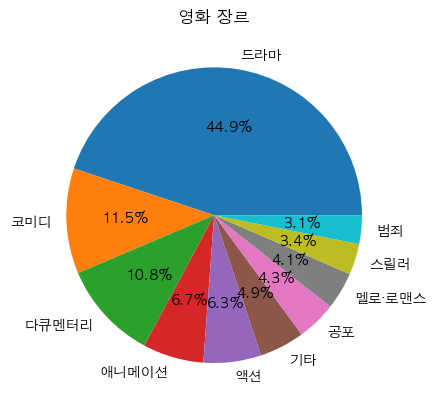

In [12]:
value = df['genre'].value_counts()
plt.rc('font', family='AppleGothic')
plt.pie(value, labels=value.index, autopct='%.1f%%')
plt.title('영화 장르')
plt.show()

In [13]:
# # 포스터 저장
# idx = 6208
# poster_link = df['poster_link'][idx:]
# for index, link in enumerate(poster_link):
#     response = requests.get(link)
#     img = Image.open(BytesIO(response.content))
#     RGB_img = img.convert('RGB')
#     id = df['id'][index+idx]
#     RGB_img.save(f"/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/영화 포스터/{df['genre'][idx+index]}/{id}.jpg")
#     print(f"{idx+index} 이미지 저장 완료")

In [36]:
# MOVIE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/영화 포스터'
# GENRE_PATH = ['멜로·로맨스,드라마', '코미디', '다큐멘터리', '애니메이션', '범죄,스릴러,서스펜스', '공포,미스터리', '액션,어드벤처,판타지,SF']
# for i in GENRE_PATH:
#     FILE_LIST = os.listdir(os.path.join(MOVIE_PATH, i))
#     for j in FILE_LIST:
#         if j.split('.')[0].isdecimal() == True:
#             image = Image.open(os.path.join(MOVIE_PATH, i, j))
#             image.save(MOVIE_PATH + '2/' + i + '/' + j)

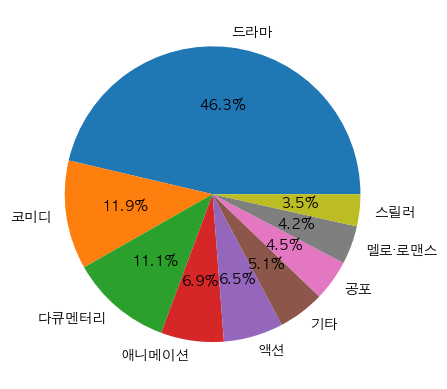

In [13]:
label_index = ['멜로·로맨스,드라마', '코미디', '다큐멘터리', '애니메이션', '범죄,스릴러,서스펜스', '공포,미스터리', '액션,어드벤처,판타지,SF']
plt.pie(value.iloc[:-1].values, labels=value.iloc[:-1].index, autopct='%1.1f%%')
plt.show()

In [14]:
def image_augment(genre_name, image_path, flip = False, elastic = False, color = False,
                  flip_elastic = False, flip_color = False, elastic_color = False):
    elastic_transform = transforms.ElasticTransform()
    flip_transform = transforms.RandomHorizontalFlip(p=1)
    color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    # brightness : 밝기, contrast : 대비, saturation : 채도, hue : 색조
    for i in df[df['genre'] == genre_name]['id']:
        image = Image.open(os.path.join(image_path, genre_name, f"{i}.jpg"))
        # 반전
        flip_image = flip_transform(image)
        # 왜곡
        elastic_image = elastic_transform(image)
        # 색상
        color_jitter_image = color_jitter(image)
        # 반전_색상
        flip_color_jitter_image = color_jitter(flip_image)
        # 반전_왜곡
        flip_elastic_image = elastic_transform(flip_image)
        # 왜곡_색상
        elastic_color_jitter_image = color_jitter(elastic_image)
        if flip == True:
            flip_image.save(os.path.join(image_path, genre_name, f"{i}_flip.jpg"))
        if elastic == True:
            elastic_image.save(os.path.join(image_path, genre_name, f"{i}_elastic.jpg"))
        if color == True:
            color_jitter_image.save(os.path.join(image_path, genre_name, f"{i}_color_jitter.jpg"))
        if flip_elastic == True:
            flip_elastic_image.save(os.path.join(image_path, genre_name, f"{i}_flip_elastic.jpg"))
        if flip_color == True:
            flip_color_jitter_image.save(os.path.join(image_path, genre_name, f"{i}_flip_color_jitter.jpg"))
        if elastic_color == True:
            elastic_color_jitter_image.save(os.path.join(image_path, genre_name, f"{i}_elastic_color_jitter.jpg"))

In [15]:
# # 코미디 4배 증강
# GENRE_NAME = '코미디'
# IMAGE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/영화 포스터'
# image_augment(GENRE_NAME, IMAGE_PATH, elastic=True, flip_color=True, flip_elastic=True)

# # 다큐멘터리 4배 증강
# GENRE_NAME = '다큐멘터리'
# IMAGE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/영화 포스터'
# image_augment(GENRE_NAME, IMAGE_PATH, elastic=True, flip_color=True, flip_elastic=True)

# # 액션,어드벤처,판타지,SF 6배 증강
# GENRE_NAME = '액션,어드벤처,판타지,SF'
# IMAGE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/영화 포스터'
# image_augment(GENRE_NAME, IMAGE_PATH, elastic=True, flip_color=True, flip_elastic=True,
#               elastic_color=True, flip=True)

# # 애니메이션 6배 증강
# GENRE_NAME = '애니메이션'
# IMAGE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/영화 포스터'
# image_augment(GENRE_NAME, IMAGE_PATH, elastic=True, color=True,
#               flip_color=True, flip_elastic=True, elastic_color=True)

# # 범죄,스릴러,서스펜스 6배 증강
# GENRE_NAME = '범죄,스릴러,서스펜스'
# IMAGE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/영화 포스터'
# image_augment(GENRE_NAME, IMAGE_PATH, elastic=True, color=True,
#               flip_color=True, flip_elastic=True, elastic_color=True)

# # 공포,미스터리 7배 증강
# GENRE_NAME = '공포,미스터리'
# IMAGE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/영화 포스터'
# image_augment(GENRE_NAME, IMAGE_PATH, flip=True, elastic=True, color=True,
#               flip_color=True, flip_elastic=True, elastic_color=True)

In [16]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 정규화 값
])

DS = datasets.ImageFolder(root='/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/영화 포스터2', transform=transform)
print(DS.classes)

['공포,미스터리', '다큐멘터리', '멜로·로맨스,드라마', '범죄,스릴러,서스펜스', '애니메이션', '액션,어드벤처,판타지,SF', '코미디']


In [17]:
image_path = [i[0] for i in DS.samples]
labels = [i[1] for i in DS.samples]
targets = [DS.classes[i[1]] for i in DS.samples]

In [18]:
random.seed(1)

drama_index_list = []
etc_index_list = []
for path, target in zip(image_path, targets):
    if target == '멜로·로맨스,드라마':
        drama_index_list.append(path)
    else:
        etc_index_list.append(path)

random_drama_list = random.sample(drama_index_list, 1800)

new_path = random_drama_list + etc_index_list
new_target = []
for i in new_path:
    new_target.append(i.split('/')[-2])

In [50]:
augment_value = pd.Series(new_target).value_counts()
augment_value

멜로·로맨스,드라마        1800
코미디               1720
다큐멘터리             1609
액션,어드벤처,판타지,SF    1178
애니메이션              994
범죄,스릴러,서스펜스        967
공포,미스터리            712
Name: count, dtype: int64

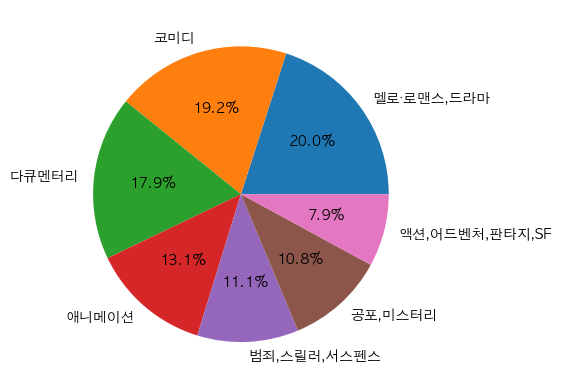

In [51]:
label_index = ['멜로·로맨스,드라마', '코미디', '다큐멘터리', '애니메이션', '범죄,스릴러,서스펜스', '공포,미스터리', '액션,어드벤처,판타지,SF']
plt.pie(augment_value.values, labels=label_index, autopct='%1.1f%%')
plt.rc('font', family='AppleGothic')
plt.show()

In [52]:
train_path, test_path, train_label, test_label = train_test_split(image_path, labels, train_size=0.8,
                                                                  stratify=labels, random_state=42)
train_path, valid_path, train_label, valid_label = train_test_split(train_path, train_label, train_size=0.8,
                                                                    stratify=train_label, random_state=42)

In [53]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labelsDF, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.labels = np.array(labelsDF)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            input_tensor = self.transform(image)

        label_tensor = torch.tensor(label, dtype=torch.float)

        return input_tensor, label_tensor

In [54]:
trainDS = CustomImageDataset(train_path, train_label, transform)
validDS = CustomImageDataset(valid_path, valid_label, transform)
testDS = CustomImageDataset(test_path, test_label, transform)

trainDL = DataLoader(trainDS, batch_size=32, shuffle=True)
validDL = DataLoader(validDS, batch_size=32, shuffle=True)
testDL = DataLoader(testDS, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


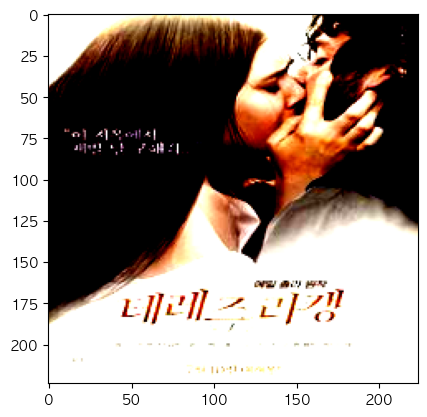

In [55]:
plt.imshow(trainDL.dataset[1][0].permute(1,2,0))
plt.show()

In [26]:
# 미리 학습된 ResNet 모델 불러오기 (weight 사용)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.fc.parameters():
    param.requires_grad = True

# 마지막 레이어 (full connected layer) 교체
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 8))

In [213]:
# 마지막 레이어 (full connected layer) 교체
# num_features = model.fc.in_features # 2048
# model.fc = nn.Linear(num_features, 8)

In [56]:
# MPS 사용 여부 확인하기
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"device : {device}")

device : mps


In [215]:
# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/ResNet50'

# 옵티마이저를 모델 파라미터에 대해 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# optimizer = torch.optim.RAdam(model.parameters(), lr=0.005)


result = training(trainDL, validDL, model, model_type = 'multiclass', optimizer = optimizer, epoch = EPOCH,
                  endurance_cnt = 10, view_epoch = 1, num_classes = 8, SAVE_PATH = SAVE_PATH, MPS = True, device = device)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 1.5014, Test : 1.3095
[Score  : 1/100] Train : 0.4428, Test : 0.5298
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 1.2368, Test : 1.2813
[Score  : 2/100] Train : 0.5481, Test : 0.5308
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 1.1695, Test : 1.1937
[Score  : 3/100] Train : 0.5714, Test : 0.5680
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 1.1110, Test : 1.1815
[Score  : 4/100] Train : 0.5907, Test : 0.5754
[Loss : 5/100] Train : 1.0599, Test : 1.1971
[Score  : 5/100] Train : 0.6110, Test : 0.5623
[EPOCH] : 6에서 모델 저장 완료.
[Loss : 6/100] Train : 1.0215, Test : 1.1372
[Score  : 6/100] Train : 0.6279, Test : 0.5895
[EPOCH] : 7에서 모델 저장 완료.
[Loss : 7/100] Train : 0.9639, Test : 1.1238
[Score  : 7/100] Train : 0.6495, Test : 0.5873
[Loss : 8/100] Train : 0.9147, Test : 1.1891
[Score  : 8/100] Train : 0.6675, Test : 0.5684
[EPOCH] : 9에서 모델 저장 완료.
[Loss : 9/100] Train : 0.8635, Test : 1.1045
[Score  : 9/100] Train : 0.6843, Test : 0.6002
[Los

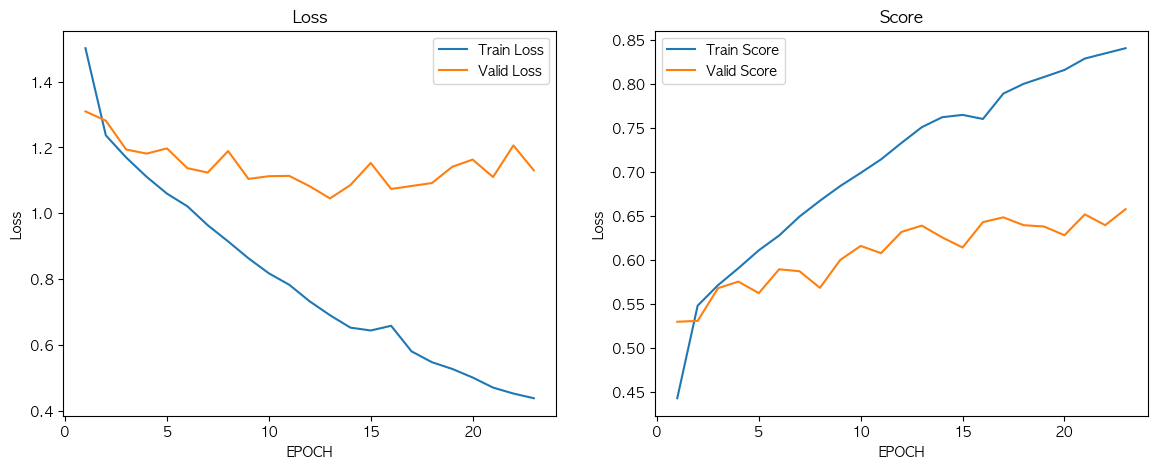

In [216]:
DrawPlot(result)
plt.show()

In [28]:
# 미리 학습된 ResNet 모델 불러오기 (weight 사용)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.fc.parameters():
    param.requires_grad = True

# 마지막 레이어 (full connected layer) 교체
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 7))

In [29]:
# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/ResNet50'

# 옵티마이저를 모델 파라미터에 대해 초기화
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)


result = training(trainDL, validDL, model, model_type = 'multiclass', optimizer = optimizer, epoch = EPOCH,
                  endurance_cnt = 10, view_epoch = 1, num_classes = 7, SAVE_PATH = SAVE_PATH, MPS = True, device = device)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 1.4459, Test : 1.2630
[Score  : 1/100] Train : 0.4527, Test : 0.5243
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 1.2133, Test : 1.2294
[Score  : 2/100] Train : 0.5478, Test : 0.5442
[Loss : 3/100] Train : 1.1457, Test : 1.2589
[Score  : 3/100] Train : 0.5718, Test : 0.5258
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 1.0911, Test : 1.0958
[Score  : 4/100] Train : 0.5927, Test : 0.5944
[Loss : 5/100] Train : 1.0345, Test : 1.1424
[Score  : 5/100] Train : 0.6150, Test : 0.5783
[EPOCH] : 6에서 모델 저장 완료.
[Loss : 6/100] Train : 0.9805, Test : 1.0697
[Score  : 6/100] Train : 0.6297, Test : 0.5981
[Loss : 7/100] Train : 0.9144, Test : 1.0717
[Score  : 7/100] Train : 0.6577, Test : 0.6008
[EPOCH] : 8에서 모델 저장 완료.
[Loss : 8/100] Train : 0.8470, Test : 1.0377
[Score  : 8/100] Train : 0.6841, Test : 0.6194
[EPOCH] : 9에서 모델 저장 완료.
[Loss : 9/100] Train : 0.7812, Test : 1.0149
[Score  : 9/100] Train : 0.7090, Test : 0.6260
[EPOCH] : 10에서 모델 저장 완료.
[Lo

KeyboardInterrupt: 

In [52]:
# 미리 학습된 ResNet 모델 불러오기 (weight 사용)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.fc.parameters():
    param.requires_grad = True

# 마지막 레이어 (full connected layer) 교체
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 7))

In [53]:
# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/ResNet50'

# 옵티마이저를 모델 파라미터에 대해 초기화
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)


result = training(trainDL, validDL, model, model_type = 'multiclass', optimizer = optimizer, epoch = EPOCH,
                  endurance_cnt = 10, view_epoch = 1, num_classes = 7, SAVE_PATH = SAVE_PATH, MPS = True, device = device)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 1.3976, Test : 1.2739
[Score  : 1/100] Train : 0.4707, Test : 0.5328
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 1.2150, Test : 1.2015
[Score  : 2/100] Train : 0.5443, Test : 0.5584
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 1.1512, Test : 1.1997
[Score  : 3/100] Train : 0.5694, Test : 0.5494
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 1.0862, Test : 1.1438
[Score  : 4/100] Train : 0.5929, Test : 0.5686
[EPOCH] : 5에서 모델 저장 완료.
[Loss : 5/100] Train : 1.0328, Test : 1.0819
[Score  : 5/100] Train : 0.6124, Test : 0.5945
[EPOCH] : 6에서 모델 저장 완료.
[Loss : 6/100] Train : 0.9720, Test : 1.0405
[Score  : 6/100] Train : 0.6362, Test : 0.6131
[Loss : 7/100] Train : 0.9030, Test : 1.0808
[Score  : 7/100] Train : 0.6591, Test : 0.6091
[EPOCH] : 8에서 모델 저장 완료.
[Loss : 8/100] Train : 0.8284, Test : 1.0083
[Score  : 8/100] Train : 0.6910, Test : 0.6328
[Loss : 9/100] Train : 0.7518, Test : 1.0223
[Score  : 9/100] Train : 0.7189, Test : 0.6351
[EPO

KeyboardInterrupt: 

In [55]:
loss_train_history = [1.3976, 1.2150, 1.1512, 1.0862, 1.0328, 0.9720, 0.9030, 0.8284, 0.7518, 0.6819, 0.6297, 0.5617, 0.5013, 0.4528, 0.4100, 0.3612, 0.3346]
loss_test_history = [1.2739, 1.2015, 1.1997, 1.1438, 1.0819, 1.0405, 1.0808, 1.0083, 1.0223, 0.9855, 1.0774, 0.9769, 0.9977, 1.0143, 1.0095, 1.1470, 1.0825]
score_train_history = [0.4707, 0.5443, 0.5694, 0.5929, 0.6124, 0.6362, 0.6591, 0.6910, 0.7189, 0.7462, 0.7602, 0.7893, 0.8116, 0.8284, 0.8486, 0.8647, 0.8754]
score_test_history = [0.5328, 0.5584, 0.5494, 0.5686, 0.5945, 0.6131, 0.6091, 0.6328, 0.6351, 0.6443, 0.6396, 0.6650, 0.6575, 0.6715, 0.6828, 0.6678, 0.6858]

result = (loss_train_history, loss_test_history, score_train_history, score_test_history)

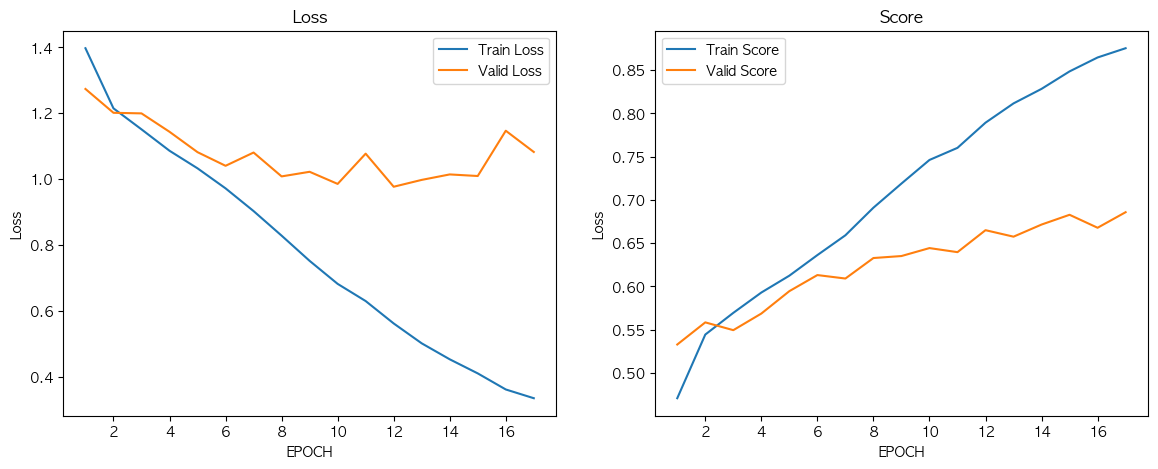

In [56]:
DrawPlot(result)
plt.show()

In [217]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [219]:
model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 8)
)

# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/EfficientNet'

# 옵티마이저를 모델 파라미터에 대해 초기화
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)

result3 = training(trainDL, validDL, model, model_type = 'multiclass', optimizer = optimizer, epoch = EPOCH,
                  endurance_cnt = 5, view_epoch = 1, num_classes = 7, SAVE_PATH = SAVE_PATH, MPS = True, device = device)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 1.5268, Test : 1.2897
[Score  : 1/100] Train : 0.4351, Test : 0.5516
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 1.1483, Test : 1.1399
[Score  : 2/100] Train : 0.5856, Test : 0.5863
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 0.8783, Test : 0.9564
[Score  : 3/100] Train : 0.6877, Test : 0.6659
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 0.5392, Test : 0.8733
[Score  : 4/100] Train : 0.8182, Test : 0.6980
[Loss : 5/100] Train : 0.2588, Test : 0.9663
[Score  : 5/100] Train : 0.9214, Test : 0.7027
[Loss : 6/100] Train : 0.1306, Test : 0.9556
[Score  : 6/100] Train : 0.9712, Test : 0.7275
[Loss : 7/100] Train : 0.0516, Test : 0.9726
[Score  : 7/100] Train : 0.9929, Test : 0.7394
[Loss : 8/100] Train : 0.0367, Test : 1.0807
[Score  : 8/100] Train : 0.9951, Test : 0.7247
[Loss : 9/100] Train : 0.0638, Test : 1.2523
[Score  : 9/100] Train : 0.9822, Test : 0.7111
[Loss : 10/100] Train : 0.0464, Test : 1.2371
[Score  : 10/100] Train : 0.98

KeyboardInterrupt: 

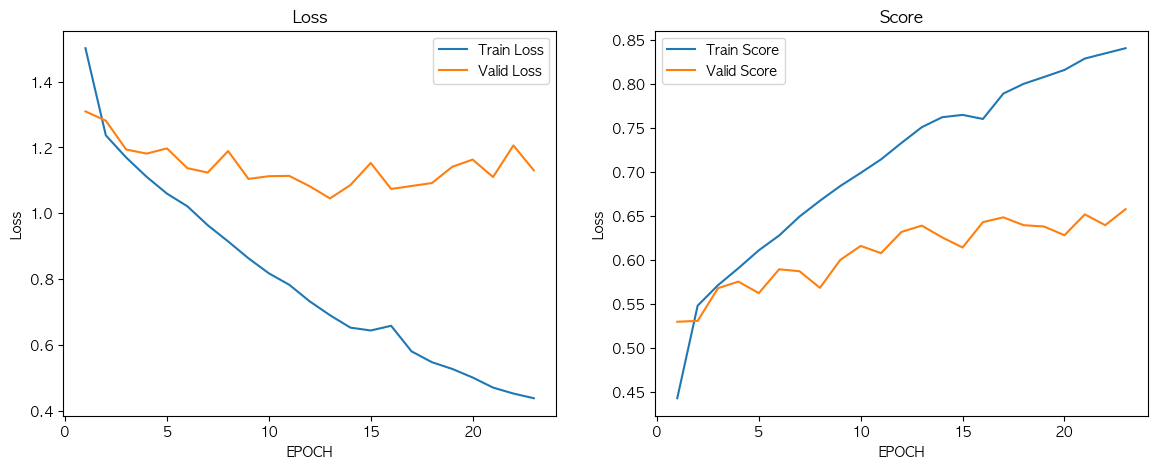

In [220]:
loss_train_history = [1.5268, 1.1483, 0.8783, 0.5392, 0.2588, 0.1306, 0.0516, 0.0367, 0.0638, 0.0464, 0.0556]
loss_test_history = [1.2897, 1.1399, 0.9564, 0.8733, 0.9663, 0.9556, 0.9726, 1.0807, 1.2523, 1.2371, 1.2352]
score_train_history = [0.4351, 0.5856, 0.6877, 0.8182, 0.9214, 0.9712, 0.9929, 0.9951, 0.9822, 0.9877, 0.9863]
score_test_history = [0.5516, 0.5863, 0.6659, 0.6980, 0.7027, 0.7275, 0.7394, 0.7247, 0.7111, 0.7293, 0.7288]

result2 = (loss_train_history, loss_test_history, score_train_history, score_test_history)

DrawPlot(result2)
plt.show()

In [57]:
# DenseNet169 모델 불러오기
model = models.densenet169(weights=DenseNet169_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 학습 가능하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

# 전결합층 변경
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 7)
)

# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/DenseNet'

# 옵티마이저를 모델 파라미터에 대해 초기화
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)

result2 = training(trainDL, validDL, model, model_type = 'multiclass', optimizer = optimizer, epoch = EPOCH,
                  endurance_cnt = 5, view_epoch = 1, num_classes = 7, SAVE_PATH = SAVE_PATH, MPS = True, device = device)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 1.3543, Test : 1.1548
[Score  : 1/100] Train : 0.5307, Test : 0.5766
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 1.1047, Test : 1.1307
[Score  : 2/100] Train : 0.6031, Test : 0.5982
[Loss : 3/100] Train : 1.0386, Test : 1.1769
[Score  : 3/100] Train : 0.6226, Test : 0.5846
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 0.9836, Test : 1.1208
[Score  : 4/100] Train : 0.6356, Test : 0.6025
[Loss : 5/100] Train : 0.9378, Test : 1.2153
[Score  : 5/100] Train : 0.6575, Test : 0.5545
[Loss : 6/100] Train : 0.8909, Test : 1.1579
[Score  : 6/100] Train : 0.6705, Test : 0.5773
[Loss : 7/100] Train : 0.8442, Test : 1.2683
[Score  : 7/100] Train : 0.6793, Test : 0.5856
[Loss : 8/100] Train : 0.7882, Test : 1.2081
[Score  : 8/100] Train : 0.7055, Test : 0.5872


KeyboardInterrupt: 

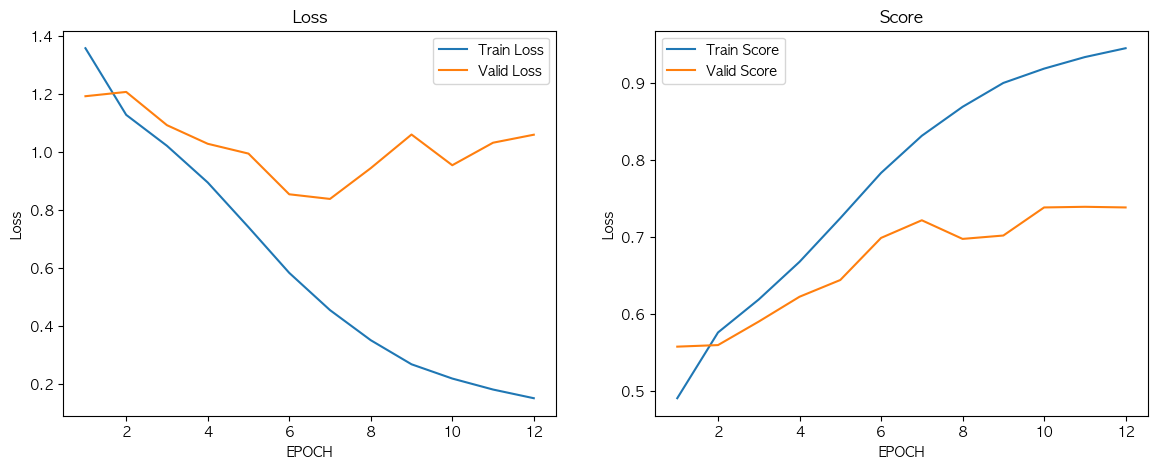

In [61]:
DrawPlot(result2)
plt.show()

In [60]:
model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 7)
)

# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/EfficientNet'

# 옵티마이저를 모델 파라미터에 대해 초기화
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)

result3 = training(trainDL, validDL, model, model_type = 'multiclass', optimizer = optimizer, epoch = EPOCH,
                  endurance_cnt = 5, view_epoch = 1, num_classes = 7, SAVE_PATH = SAVE_PATH, MPS = True, device = device)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 1.4598, Test : 1.2613
[Score  : 1/100] Train : 0.4478, Test : 0.5481
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 1.1092, Test : 1.1187
[Score  : 2/100] Train : 0.5934, Test : 0.5837
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 0.7848, Test : 0.9108
[Score  : 3/100] Train : 0.7135, Test : 0.6740
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 0.4026, Test : 0.8418
[Score  : 4/100] Train : 0.8556, Test : 0.7244
[Loss : 5/100] Train : 0.1870, Test : 1.0256
[Score  : 5/100] Train : 0.9348, Test : 0.7295
[Loss : 6/100] Train : 0.1242, Test : 1.1158
[Score  : 6/100] Train : 0.9568, Test : 0.7278
[Loss : 7/100] Train : 0.0970, Test : 1.2124
[Score  : 7/100] Train : 0.9660, Test : 0.7234
[Loss : 8/100] Train : 0.0788, Test : 1.2811
[Score  : 8/100] Train : 0.9741, Test : 0.7367
[Loss]값의 개선이 이루어지지 않아 [9] EPOCH에서 학습을 종료합니다.


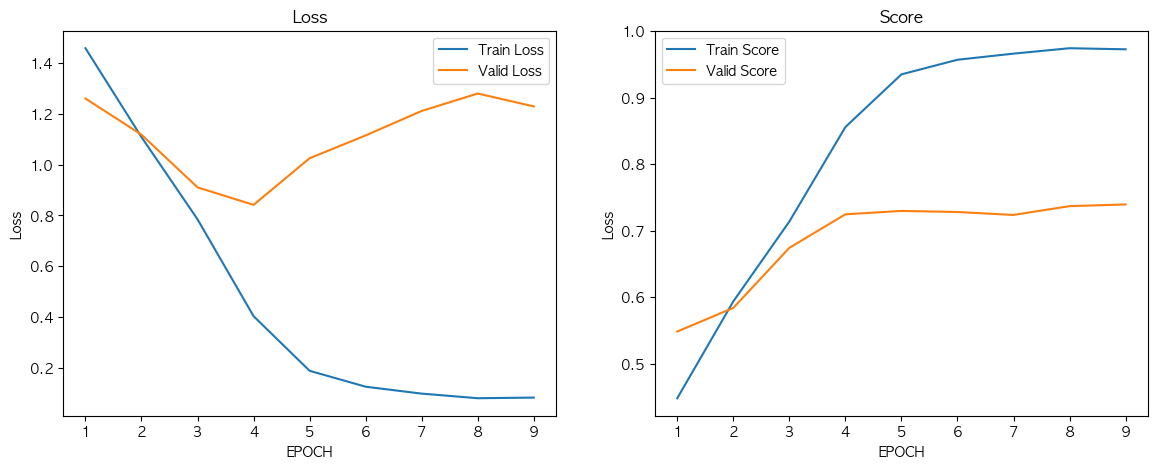

In [62]:
DrawPlot(result3)
plt.show()